## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="0" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()





def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)
    e = np.random.gumbel(mean, var, SIZE)
    f= a + b + c + d + e + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)

    f= a + b + c + d + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    
    
    g = np.rint(g)
    e = g + np.random.gumbel(mean,var,SIZE)
    
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def gen_data(mean = 0, var = 1, SIZE = 400000):
    f = np.random.normal(mean, var, SIZE)
    a = f + np.random.normal(mean, var, SIZE)
    b = f + np.random.normal(mean, var, SIZE)
    c = f + np.random.normal(mean, var, SIZE)
    d = f + np.random.normal(mean, var, SIZE)
    e = f + np.random.normal(mean, var, SIZE)
    g = a + b + c + d  + e + np.random.normal(mean, var, SIZE)

    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 20000):
    a = np.random.normal(mean, var, SIZE)
    b = a + np.random.normal(mean, var, SIZE)
    c = a + np.random.normal(mean, var, SIZE)
    e = a + np.random.normal(mean, var, SIZE)
    d = a + np.random.normal(mean, var, SIZE)
    
    f= a + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    #g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 20000): #### THIS ONE HAS F AND G SWAPPED
    a = np.random.normal(mean, var, SIZE)
    b = a + np.random.normal(mean, var, SIZE)
    c =  b + np.random.normal(mean, var, SIZE)
    
    e = np.random.normal(mean, var, SIZE)
    
    d = e + b + np.random.normal(mean, var, SIZE)
    
    g= b +  d + np.random.normal(mean, var, SIZE)
    f = g + np.random.normal(mean,var, SIZE)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})



def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()


verbosity = 1



models = []
model_names = []

num_models = 50
model_layers = [2048, 2048, 512]
for i in range(num_models):
    models.append(model_layers)
    model_names.append('temp/a' + str(i))

print(models, model_names)


df = gen_data()
X = df[['a', 'b', 'c', 'd', 'e', 'f']].values
y = df['g'].values

val_df = gen_data(SIZE = 2000)
x_val = df[['a', 'b', 'c', 'd', 'e', 'f']].values
y_val = df['g'].values



/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[[2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512]] ['temp/a0', 'temp/a1', 'temp/a2', 'temp/a3', 'tem

In [3]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), 6)
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/a0
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 174us/step - loss: 0.7066 - mean_squared_error: 0.7066 - val_loss: 0.5624 - val_mean_squared_error: 0.5624

Epoch 00001: val_loss improved from inf to 0.56241, saving model to temp/a0
Epoch 2/20
20000/20000 [==============================] - 3s 127us/step - loss: 0.5593 - mean_squared_error: 0.5593 - val_loss: 0.5725 - val_mean_squared_error: 0.5725

Epoch 00002: val_loss did not improve from 0.56241
Epoch 3/20
20000/20000 [==============================] - 3s 125us/step - loss: 0.5560 - mean_squared_error: 0.5560 - val_loss: 0.5404 - val_mean_squared_error: 0.5404

Epoch 00003: val_loss improved from 0.56241 to 0.54043, saving model to temp/a0
Epoch 4/20
20000/20000 [==============================] - 3s 128us/step - loss: 0.5509 - mean_squared_error: 0.5509 - val_loss: 0.5358 - val_mean_squared_error: 0.5358

Epoch 00004: val_loss improved from 0.54043 to 0.53583, sav


Epoch 00001: val_loss improved from inf to 0.59724, saving model to temp/a5
Epoch 2/20
20000/20000 [==============================] - 3s 126us/step - loss: 0.5600 - mean_squared_error: 0.5600 - val_loss: 0.5438 - val_mean_squared_error: 0.5438

Epoch 00002: val_loss improved from 0.59724 to 0.54378, saving model to temp/a5
Epoch 3/20
20000/20000 [==============================] - 3s 132us/step - loss: 0.5526 - mean_squared_error: 0.5526 - val_loss: 0.5426 - val_mean_squared_error: 0.5426

Epoch 00003: val_loss improved from 0.54378 to 0.54257, saving model to temp/a5
Epoch 4/20
20000/20000 [==============================] - 3s 129us/step - loss: 0.5502 - mean_squared_error: 0.5502 - val_loss: 0.5640 - val_mean_squared_error: 0.5640

Epoch 00004: val_loss did not improve from 0.54257
Epoch 5/20
20000/20000 [==============================] - 3s 129us/step - loss: 0.5487 - mean_squared_error: 0.5487 - val_loss: 0.5744 - val_mean_squared_error: 0.5744

Epoch 00005: val_loss did not improv

20000/20000 [==============================] - 3s 147us/step - loss: 0.6983 - mean_squared_error: 0.6983 - val_loss: 0.5734 - val_mean_squared_error: 0.5734

Epoch 00001: val_loss improved from inf to 0.57343, saving model to temp/a12
Epoch 2/20
20000/20000 [==============================] - 3s 129us/step - loss: 0.5558 - mean_squared_error: 0.5558 - val_loss: 0.5761 - val_mean_squared_error: 0.5761

Epoch 00002: val_loss did not improve from 0.57343
Epoch 3/20
20000/20000 [==============================] - 3s 130us/step - loss: 0.5516 - mean_squared_error: 0.5516 - val_loss: 0.5424 - val_mean_squared_error: 0.5424

Epoch 00003: val_loss improved from 0.57343 to 0.54245, saving model to temp/a12
Epoch 4/20
20000/20000 [==============================] - 3s 127us/step - loss: 0.5541 - mean_squared_error: 0.5541 - val_loss: 0.5444 - val_mean_squared_error: 0.5444

Epoch 00004: val_loss did not improve from 0.54245
Epoch 5/20
20000/20000 [==============================] - 3s 128us/step - l

20000/20000 [==============================] - 3s 128us/step - loss: 0.5601 - mean_squared_error: 0.5601 - val_loss: 0.5421 - val_mean_squared_error: 0.5421

Epoch 00002: val_loss improved from 0.55467 to 0.54208, saving model to temp/a18
Epoch 3/20
20000/20000 [==============================] - 3s 131us/step - loss: 0.5519 - mean_squared_error: 0.5519 - val_loss: 0.5378 - val_mean_squared_error: 0.5378

Epoch 00003: val_loss improved from 0.54208 to 0.53784, saving model to temp/a18
Epoch 4/20
20000/20000 [==============================] - 3s 127us/step - loss: 0.5510 - mean_squared_error: 0.5510 - val_loss: 0.5720 - val_mean_squared_error: 0.5720

Epoch 00004: val_loss did not improve from 0.53784
Epoch 5/20
20000/20000 [==============================] - 3s 128us/step - loss: 0.5499 - mean_squared_error: 0.5499 - val_loss: 0.5401 - val_mean_squared_error: 0.5401

Epoch 00005: val_loss did not improve from 0.53784
Epoch 00005: early stopping
temp/a19
Train on 20000 samples, validate o

20000/20000 [==============================] - 3s 138us/step - loss: 0.5522 - mean_squared_error: 0.5522 - val_loss: 0.5394 - val_mean_squared_error: 0.5394

Epoch 00004: val_loss improved from 0.54274 to 0.53943, saving model to temp/a22
Epoch 5/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.5491 - mean_squared_error: 0.5491 - val_loss: 0.5432 - val_mean_squared_error: 0.5432

Epoch 00005: val_loss did not improve from 0.53943
Epoch 6/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.5448 - mean_squared_error: 0.5448 - val_loss: 0.5509 - val_mean_squared_error: 0.5509

Epoch 00006: val_loss did not improve from 0.53943
Epoch 00006: early stopping
temp/a23
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 150us/step - loss: 0.7152 - mean_squared_error: 0.7152 - val_loss: 0.5627 - val_mean_squared_error: 0.5627

Epoch 00001: val_loss improved from inf to 0.56271, saving model 

20000/20000 [==============================] - 3s 139us/step - loss: 0.5535 - mean_squared_error: 0.5535 - val_loss: 0.5349 - val_mean_squared_error: 0.5349

Epoch 00004: val_loss improved from 0.54067 to 0.53488, saving model to temp/a28
Epoch 5/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.5517 - mean_squared_error: 0.5517 - val_loss: 0.5557 - val_mean_squared_error: 0.5557

Epoch 00005: val_loss did not improve from 0.53488
Epoch 6/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.5440 - mean_squared_error: 0.5440 - val_loss: 0.5394 - val_mean_squared_error: 0.5394

Epoch 00006: val_loss did not improve from 0.53488
Epoch 00006: early stopping
temp/a29
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 151us/step - loss: 0.7070 - mean_squared_error: 0.7070 - val_loss: 0.5711 - val_mean_squared_error: 0.5711

Epoch 00001: val_loss improved from inf to 0.57114, saving model 

20000/20000 [==============================] - 3s 138us/step - loss: 0.5562 - mean_squared_error: 0.5562 - val_loss: 0.5460 - val_mean_squared_error: 0.5460

Epoch 00002: val_loss improved from 0.56906 to 0.54596, saving model to temp/a33
Epoch 3/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.5477 - mean_squared_error: 0.5477 - val_loss: 0.5443 - val_mean_squared_error: 0.5443

Epoch 00003: val_loss improved from 0.54596 to 0.54428, saving model to temp/a33
Epoch 4/20
20000/20000 [==============================] - 3s 136us/step - loss: 0.5481 - mean_squared_error: 0.5481 - val_loss: 0.5454 - val_mean_squared_error: 0.5454

Epoch 00004: val_loss did not improve from 0.54428
Epoch 5/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.5457 - mean_squared_error: 0.5457 - val_loss: 0.5418 - val_mean_squared_error: 0.5418

Epoch 00005: val_loss improved from 0.54428 to 0.54180, saving model to temp/a33
Epoch 6/20
20000/20000 [=================

20000/20000 [==============================] - 3s 138us/step - loss: 0.5498 - mean_squared_error: 0.5498 - val_loss: 0.5546 - val_mean_squared_error: 0.5546

Epoch 00005: val_loss did not improve from 0.53709
Epoch 6/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.5454 - mean_squared_error: 0.5454 - val_loss: 0.5464 - val_mean_squared_error: 0.5464

Epoch 00006: val_loss did not improve from 0.53709
Epoch 00006: early stopping
temp/a38
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 151us/step - loss: 0.7433 - mean_squared_error: 0.7433 - val_loss: 0.5571 - val_mean_squared_error: 0.5571

Epoch 00001: val_loss improved from inf to 0.55711, saving model to temp/a38
Epoch 2/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.5601 - mean_squared_error: 0.5601 - val_loss: 0.5616 - val_mean_squared_error: 0.5616

Epoch 00002: val_loss did not improve from 0.55711
Epoch 3/20
20000/2

20000/20000 [==============================] - 3s 137us/step - loss: 0.5484 - mean_squared_error: 0.5484 - val_loss: 0.5409 - val_mean_squared_error: 0.5409

Epoch 00003: val_loss improved from 0.54154 to 0.54091, saving model to temp/a43
Epoch 4/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.5540 - mean_squared_error: 0.5540 - val_loss: 0.5398 - val_mean_squared_error: 0.5398

Epoch 00004: val_loss improved from 0.54091 to 0.53980, saving model to temp/a43
Epoch 5/20
20000/20000 [==============================] - 3s 136us/step - loss: 0.5467 - mean_squared_error: 0.5467 - val_loss: 0.5423 - val_mean_squared_error: 0.5423

Epoch 00005: val_loss did not improve from 0.53980
Epoch 6/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.5445 - mean_squared_error: 0.5445 - val_loss: 0.5479 - val_mean_squared_error: 0.5479

Epoch 00006: val_loss did not improve from 0.53980
Epoch 00006: early stopping
temp/a44
Train on 20000 samples, validate o

20000/20000 [==============================] - 3s 138us/step - loss: 0.5461 - mean_squared_error: 0.5461 - val_loss: 0.5392 - val_mean_squared_error: 0.5392

Epoch 00006: val_loss improved from 0.53976 to 0.53922, saving model to temp/a48
Epoch 7/20
20000/20000 [==============================] - 3s 133us/step - loss: 0.5430 - mean_squared_error: 0.5430 - val_loss: 0.5340 - val_mean_squared_error: 0.5340

Epoch 00007: val_loss improved from 0.53922 to 0.53397, saving model to temp/a48
Epoch 8/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.5403 - mean_squared_error: 0.5403 - val_loss: 0.5486 - val_mean_squared_error: 0.5486

Epoch 00008: val_loss did not improve from 0.53397
Epoch 9/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.5431 - mean_squared_error: 0.5431 - val_loss: 0.5397 - val_mean_squared_error: 0.5397

Epoch 00009: val_loss did not improve from 0.53397
Epoch 00009: early stopping
temp/a49
Train on 20000 samples, validate o

In [4]:
nb_test = 2000
metrics_dicts = []
for m in models:
    metrics_dicts.append(defaultdict(list))


#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0, 1, 2]
variances = [1,2,3]


# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print(m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df['g']
        x_test2 = perturbed_df[['a', 'b', 'c', 'd', 'e', 'f']]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))

            test_df2 = pd.DataFrame(x_test2, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
            test_targets2 = pd.DataFrame(model.predict(x_test2), columns = ['g'])
            test_df2 = test_df2.join(test_targets2)
'''
            setA = get_MB(get_CG(perturbed_df, tetrad), 'g', pc)
            if setA != {'f'}:
                print("Error in SETA markov blanket")
                #setA = {'f'}
            setC = get_MB(get_CG(test_df2, tetrad), 'g', pc)

            if setA != setC:
                causal_dicts[idx][str(m) + '_' + str(v)].append(1)
            else:
                causal_dicts[idx][str(m) + '_' + str(v)].append(0)

'''




0 1
0 2
0 3
1 1
1 2
1 3
2 1
2 2
2 3


'\n            setA = get_MB(get_CG(perturbed_df, tetrad), \'g\', pc)\n            if setA != {\'f\'}:\n                print("Error in SETA markov blanket")\n                #setA = {\'f\'}\n            setC = get_MB(get_CG(test_df2, tetrad), \'g\', pc)\n\n            if setA != setC:\n                causal_dicts[idx][str(m) + \'_\' + str(v)].append(1)\n            else:\n                causal_dicts[idx][str(m) + \'_\' + str(v)].append(0)\n\n'

# USING BIC

In [5]:
#the number of times to sample
times = 5

## the size of the test set


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

from pycausal import prior as p
def get_bic(df, prior):

    tetrad.run(algoId = 'gfci', dfs = df,  scoreId = 'sem-bic-deterministic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = 200
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.combinations(lst,2):
        a.add(i)
    return a

full_conx = get_pairs(['a', 'b', 'c', 'd', 'e', 'f', 'g'])
forced_conx = set({('a','f'), ('b','f'),('c','f'),('d','f'),('e','d'),('f','g')})
restricted_conx = full_conx.difference(forced_conx)   
prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       forbiddirect = list(map(list, restricted_conx))
                       )




for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[['a', 'b', 'c', 'd', 'e', 'f']].values
    y_test = df_test['g'].values
    bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
        test_targets = pd.DataFrame(model.predict(x_test), columns = ['g'])
        test_df = test_df.join(test_targets)
       
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test)) 
        bic_pred = get_bic(test_df,prior)
        print(tetrad.getEdges())
        print(bic_orig, bic_pred)
        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)

Times =  0
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26983.53420171551 -26851.810519611947
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26983.53420171551 -26852.645350422383
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26983.53420171551 -26805.570341100338
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26983.53420171551 -26871.90155034392
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26983.53420171551 -26871.764359286914
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26983.53420171551 -26910.224983308515
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26983.53420171551 -26918.288609379764
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26983.53420171551 -26880.842501931274
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26983.53420171551 -26854.154755585027
['a --> f', 'b --> f', 'e --> d', 'c

['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26535.878792685715 -26462.84297628046
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26535.878792685715 -26459.742973110842
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26535.878792685715 -26446.570395747447
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26535.878792685715 -26441.734656715467
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26535.878792685715 -26418.17403273666
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26535.878792685715 -26431.746485791755
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26535.878792685715 -26438.98288080902
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26535.878792685715 -26420.463365803877
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26535.878792685715 -26477.601650574594
['a --> f', 'b --> f', 'e --> d', 'c -->

['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26465.2015363637 -26376.550611313545
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26465.2015363637 -26381.431566189283
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26465.2015363637 -26321.836143765784
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26465.2015363637 -26316.04042482039
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26465.2015363637 -26470.794029518147
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26465.2015363637 -26387.89202448435
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26465.2015363637 -26375.442709512135
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26465.2015363637 -26323.11331456688
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26465.2015363637 -26351.84557746486
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f 

['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26791.58288497656 -26602.09003915656
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26791.58288497656 -26653.05559895411
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26791.58288497656 -26593.314003433647
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26791.58288497656 -26678.71600543239
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26791.58288497656 -26604.275750316003
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26791.58288497656 -26615.256180429875
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26791.58288497656 -26625.16676346184
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26791.58288497656 -26647.532776773627
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --> f', 'f --> g']
-26791.58288497656 -26761.041977355177
['a --> f', 'b --> f', 'e --> d', 'c --> f', 'd --

Model_name =  temp/a0 Violations =  0.0
Average_violations =  -26575.126221964136 195.47858606315975
MSE =  0.538216346800696 0.019925424286091658
Model_name =  temp/a1 Violations =  0.0
Average_violations =  -26584.071399083266 194.97054880148542
MSE =  0.5418335930368255 0.012185610557102508
Model_name =  temp/a2 Violations =  0.0
Average_violations =  -26543.77455650915 192.01863897535424
MSE =  0.5393656580900925 0.013635292191931853
Model_name =  temp/a3 Violations =  0.0
Average_violations =  -26577.440630851394 207.39691089528506
MSE =  0.547464620930221 0.014845793676432484
Model_name =  temp/a4 Violations =  0.0
Average_violations =  -26602.83254689349 190.8437042955155
MSE =  0.5415427056960167 0.013422314961854752
Model_name =  temp/a5 Violations =  0.0
Average_violations =  -26644.568985795377 191.64123650349552
MSE =  0.5443045702833308 0.0170516280954923
Model_name =  temp/a6 Violations =  0.0
Average_violations =  -26652.08441330601 191.00505669754097
MSE =  0.5501971244

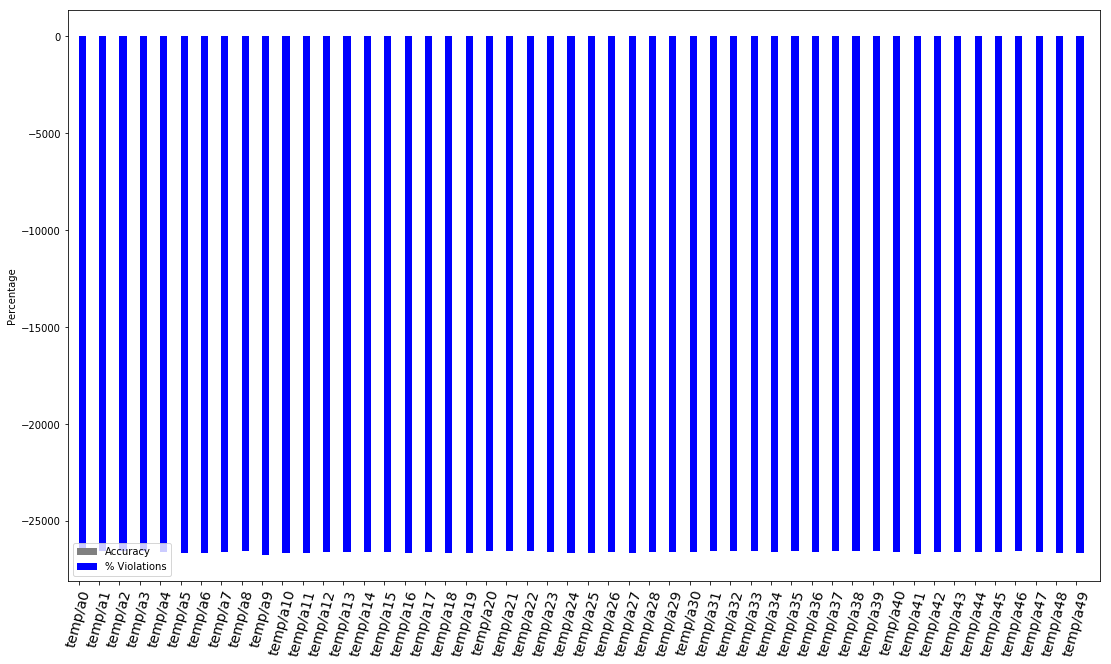

temp/a0
Area under surface (rectangular approx) =  25.73210381298803
Violations =  0.0
Average_violations =  -26575.126221964136
MSE =  0.538216346800696
temp/a1
Area under surface (rectangular approx) =  25.90259266299641
Violations =  0.0
Average_violations =  -26584.071399083266
MSE =  0.5418335930368255
temp/a2
Area under surface (rectangular approx) =  25.910507765314954
Violations =  0.0
Average_violations =  -26543.77455650915
MSE =  0.5393656580900925
temp/a3
Area under surface (rectangular approx) =  25.70857589737276
Violations =  0.0
Average_violations =  -26577.440630851394
MSE =  0.547464620930221
temp/a4
Area under surface (rectangular approx) =  25.3009963772926
Violations =  0.0
Average_violations =  -26602.83254689349
MSE =  0.5415427056960167
temp/a5
Area under surface (rectangular approx) =  25.81882777430131
Violations =  0.0
Average_violations =  -26644.568985795377
MSE =  0.5443045702833308
temp/a6
Area under surface (rectangular approx) =  26.611488134571697
Viol

In [6]:
metric = []
metric_err = []
viol = []
viol_err = []

#normalize the violations for prettier graphing.
#also violations are always positive, so just divide by max.

#TMK
#violation_mean = violation_mean / np.max(violation_mean)

for i in range(len(violations)):
    print("Model_name = ", model_names[i], "Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]), np.std(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]), np.std(mean[i]))
    #print("mean = ", mean[i])
    metric.append(np.mean(mean[i]))
    metric_err.append(np.std(mean[i]))
    viol.append(np.mean(violation_mean[i]))
    #viol.append(violations[i]/times)
    viol_err.append(np.std(violation_mean[i]))
print(np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))    

bar_plot(model_names, 
         np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))


def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=450, edgecolor='')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.colorbar(cax)
    plt.show()

    
MSE = []
VIO = []
VIO2 = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))
    VIO2.append(np.mean(violation_mean2[i]))
    #VIO.append(violations[i]/times)
    AUS.append(rectangular_approx)
    
    #heat_plot(x,y,z, clim_low = 0, clim_high = 10)
    
#heat_plot(MSE,VIO,AUS, xlab = 'MSE', ylab='Violations', clim_low = np.min(AUS), clim_high = np.max(AUS))
    
#VIO = np.abs(VIO)
#VIO2 = np.abs(VIO2)


0.0029388608267132896


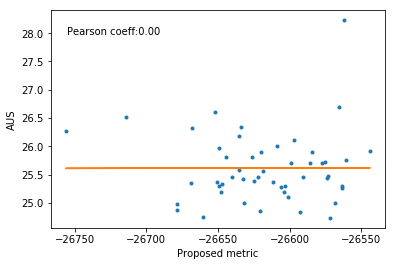

0.6458421593582494


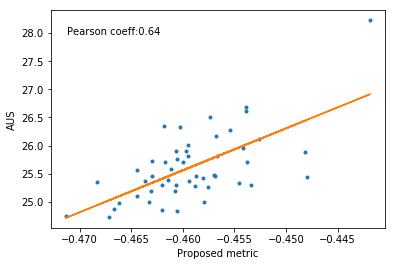

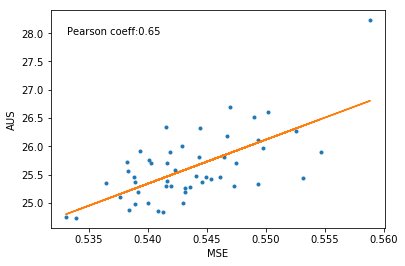

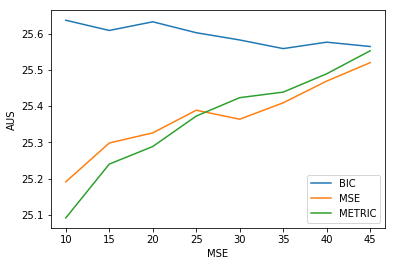

0.6458421593582494

In [7]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text


print(pearsonr(VIO,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
ax.plot(VIO,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("Proposed metric")
ax.set_ylabel("AUS")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


METRIC = -(VIO/np.max(VIO)) + np.array(MSE)
print(pearsonr(METRIC,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("AUS")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


MSE = np.array(MSE)

x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low))
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'BIC')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  
pearsonr(METRIC,AUS)[0]